## Future price and mid-price in Stoikov hft mm strategy 

https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf

* Implemented dynamic volatility (removed $\kappa$) for classic stoikov strategy
* Comparing 2 approaches - static vol, dynamic vol


* Implemented straty with 'predicator' 
* Comparing 3 strategies - **Stoikov, Stoikov with future price, Stoikov with mid price**

* Liquidation strategies


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

from simulator import Sim
from strategies import StoikovStrategyOriginal, StoikovStrategy, FutureStrategy
from get_info import get_pnl
from load_data import load_md_from_file

from sklearn.model_selection import ParameterGrid

PATH_TO_FILE = 'md/btcusdt:Binance:LinearPerpetual/'

In [2]:
T = pd.Timedelta(1, 'h').delta
md = load_md_from_file(path=PATH_TO_FILE, T=T)

### 1. Comparing 2 approaches - static vol, dynamic vol

In [3]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.5, 's').delta

min_pos = 0.001

In [4]:
gamma = 1

In [5]:
T = pd.Timedelta(1, 's').delta

In [27]:
stoikov = StoikovStrategyOriginal(delay = delay, theta = 1, gamma = gamma, k = 1)
stoikov_dynamic_std = StoikovStrategy(delay=delay, min_pos=min_pos, time_memory=T, gamma=gamma, theta_policy='std')
stoikov_dynamic_std_2s = StoikovStrategy(delay=delay, min_pos=min_pos, time_memory=2*T, gamma=gamma, theta_policy='std')
stoikov_dynamic_spread = StoikovStrategy(delay=delay, min_pos=min_pos, time_memory=T, gamma=gamma, theta_policy='spread')

strats = {
    'stoikov_original' : stoikov,
    'stoikov_dynamic_std': stoikov_dynamic_std,
    'stoikov_dynamic_std_2s': stoikov_dynamic_std_2s,
    'stoikov_dynamic_spread': stoikov_dynamic_spread, 
}

In [28]:
res = {}
dfs = {}

for name, strat in strats.items():
    res[name] = strat.run(sim = Sim(md, latency, md_latency))
    dfs[name] = get_pnl(res[name]['update'])

### PnL

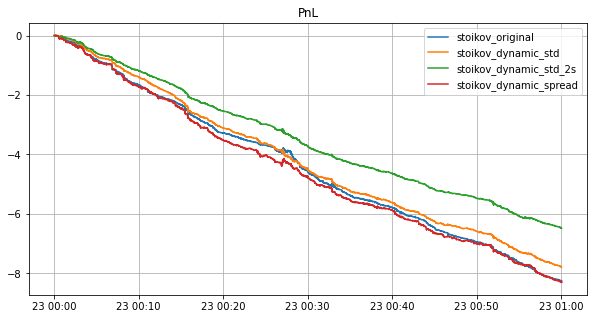

In [29]:
plt.figure(figsize=(10, 5))
plt.title("PnL")
for name, df in dfs.items():

    dt = pd.to_datetime(df.receive_ts)

    plt.step(dt, df.total, '-', label=name)
plt.legend()
plt.grid()
plt.show()

* As we can see dynamic volatility outperformes static

### Reserves balance

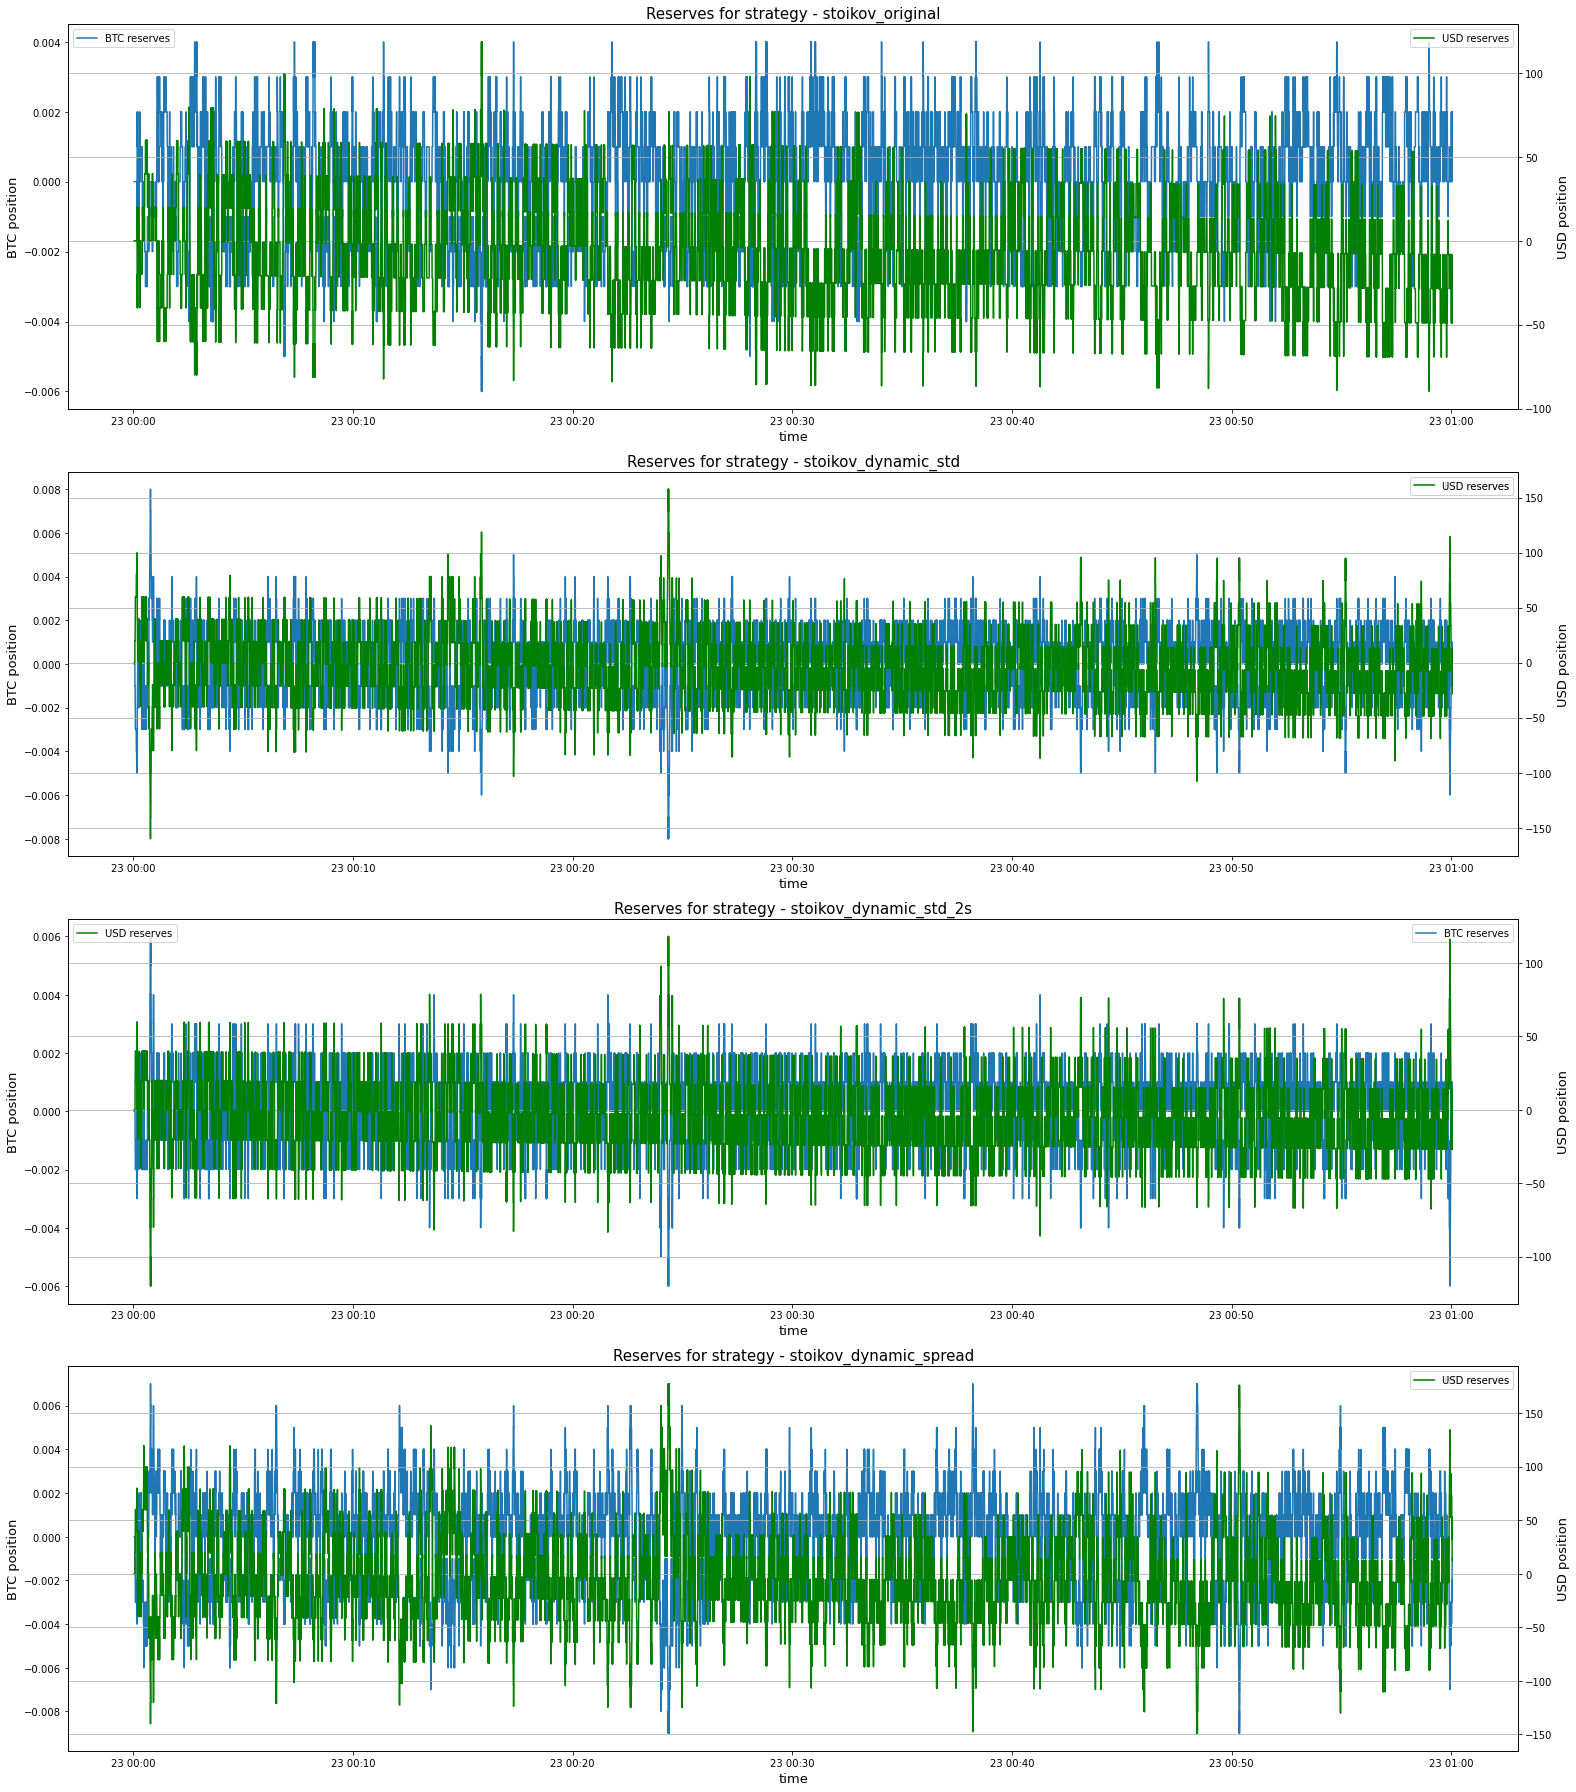

In [43]:
plt.figure(figsize=(22, 25))
i = 0

for name, df in dfs.items():
    i+=1
    dt = pd.to_datetime(df.receive_ts)
    ax1 = plt.subplot(4, 1, i)
    ax2 = ax1.twinx()
    ax1.plot(dt, df.BTC, '-', label='BTC reserves')
    ax2.plot(dt, df.USD, '-', color='g', label='USD reserves')
    ax1.set_xlabel("time", fontsize=13)
    ax1.set_ylabel("BTC position", fontsize=13)
    ax2.set_ylabel("USD position", fontsize=13)
    ax1.legend()
    ax2.legend()
    plt.title("Reserves for strategy - " + name, fontsize=15)
    plt.grid()

plt.tight_layout()
plt.show()

### Traded volume

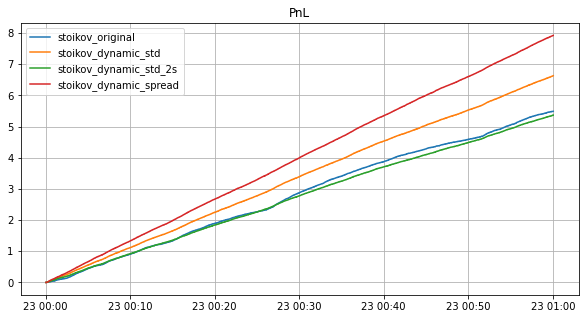

In [46]:
plt.figure(figsize=(10, 5))
plt.title("PnL")
for name, df in dfs.items():

    dt = pd.to_datetime(df.receive_ts)

    plt.step(dt, df.traded_volume, '-', label=name)
plt.legend()
plt.grid()
plt.show()

* Trading volumes are pretty similar

### 2. Future price strategy - comparing 3 strategies - future price, reservation price, mid_price 

In [6]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.5, 's').delta

min_pos = 0.001

In [7]:
gamma = 1

In [8]:
T = pd.Timedelta(1, 's').delta

In [9]:
stoikov = StoikovStrategy(delay=delay, min_pos=min_pos, time_memory=T, gamma=gamma, theta_policy='std')
stoikov_mid_price = StoikovStrategy(delay=delay, min_pos=min_pos, time_memory=T, gamma=gamma, theta_policy='std', res_policy='mid_price')
stoikov_future_price = FutureStrategy(delay=delay, min_pos=min_pos, time_memory=T, gamma=gamma, theta_policy='std', md = md)

strats = {
    'stoikov' : stoikov,
    'stoikov_mid_price': stoikov_mid_price,
    'stoikov_future_price': stoikov_future_price, 
}

In [10]:
res = {}
dfs = {}

for name, strat in strats.items():
    res[name] = strat.run(sim = Sim(md, latency, md_latency))
    dfs[name] = get_pnl(res[name]['update'])

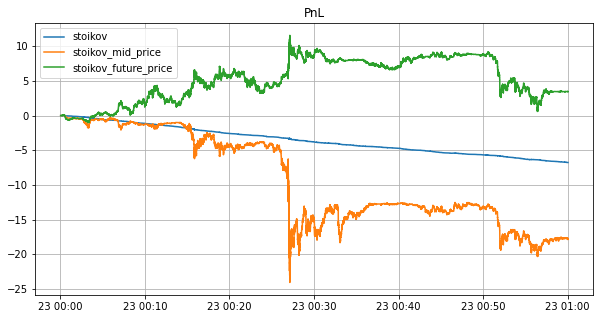

In [11]:
plt.figure(figsize=(10, 5))
plt.title("PnL")
for name, df in dfs.items():

    dt = pd.to_datetime(df.receive_ts)

    plt.step(dt, df.total, '-', label=name)
plt.legend()
plt.grid()
plt.show()

* As we can see future price strategy does good in terms of PnL

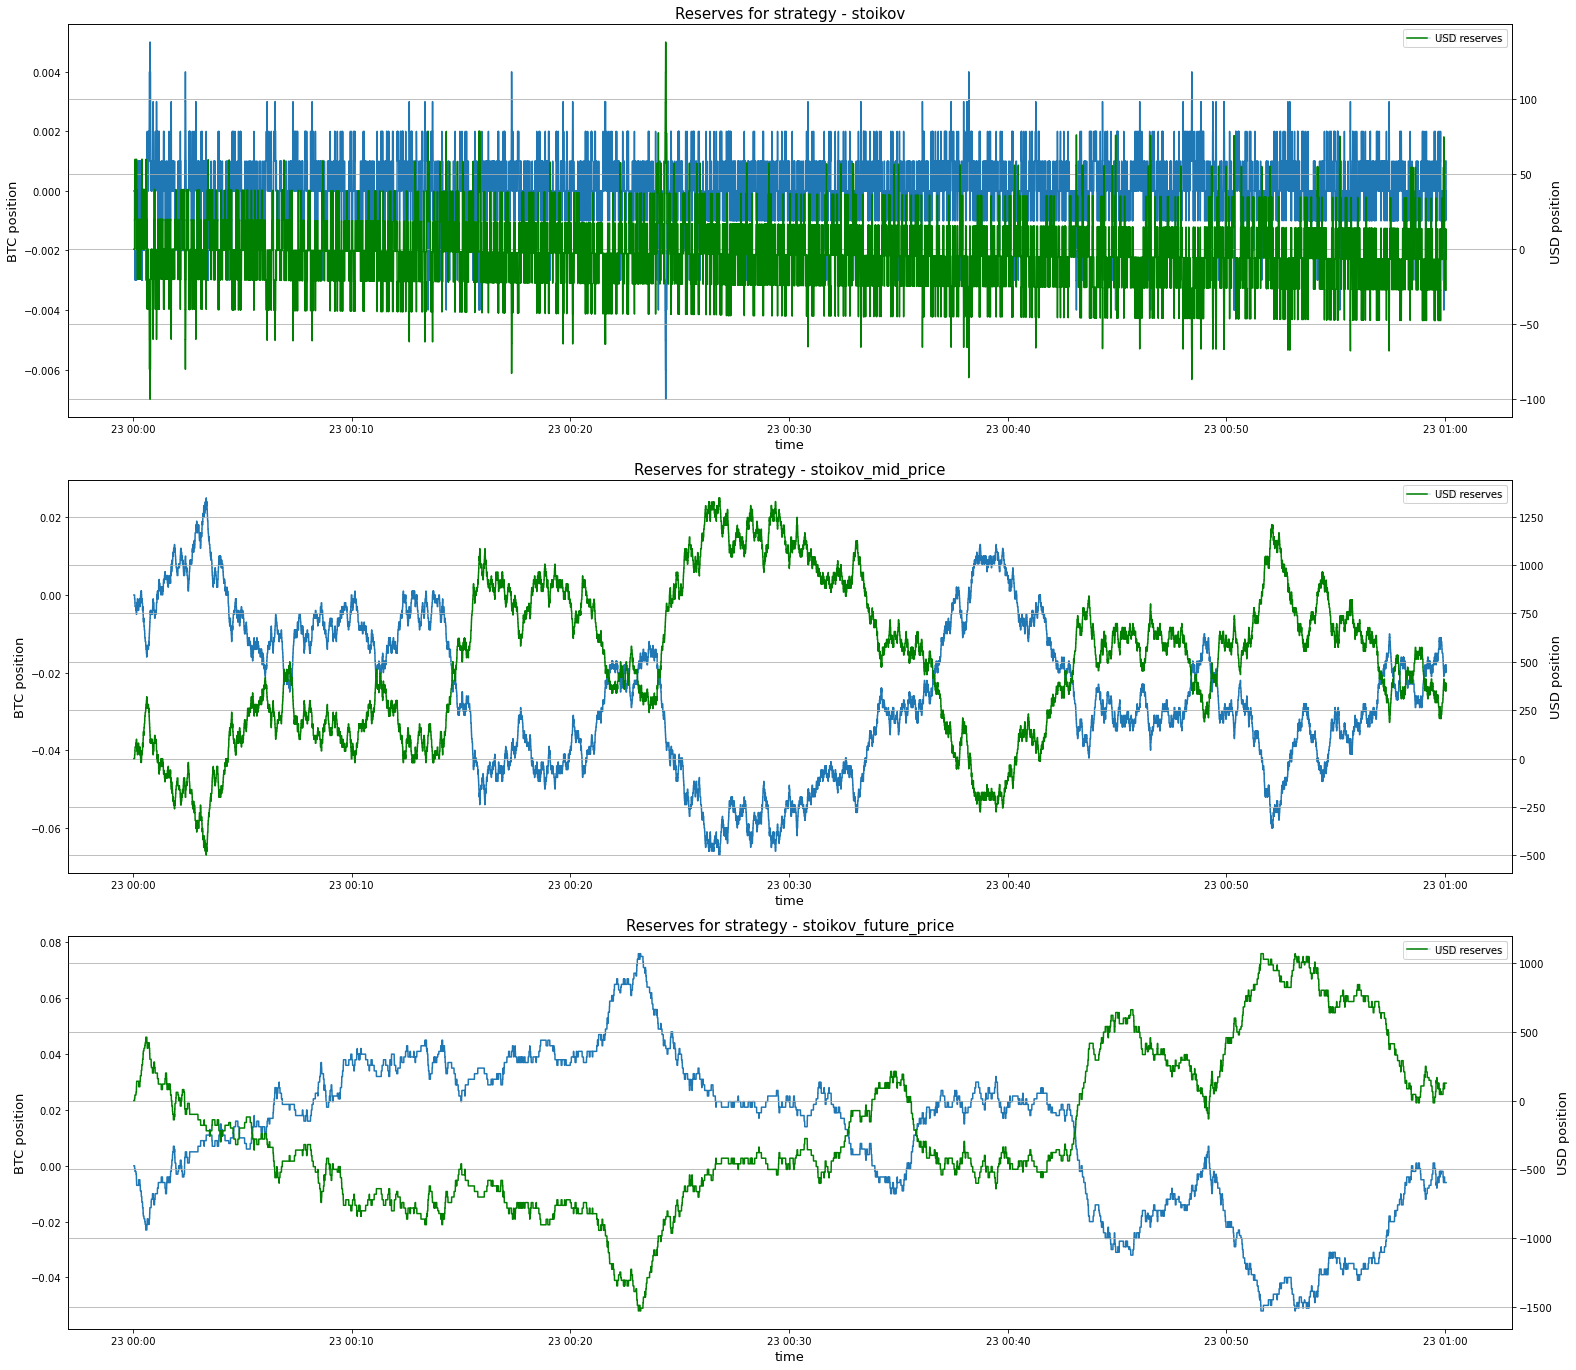

In [13]:
plt.figure(figsize=(22, 25))
i = 0

for name, df in dfs.items():
    i+=1
    dt = pd.to_datetime(df.receive_ts)
    ax1 = plt.subplot(4, 1, i)
    ax2 = ax1.twinx()
    ax1.plot(dt, df.BTC, '-', label='BTC reserves')
    ax2.plot(dt, df.USD, '-', color='g', label='USD reserves')
    ax1.set_xlabel("time", fontsize=13)
    ax1.set_ylabel("BTC position", fontsize=13)
    ax2.set_ylabel("USD position", fontsize=13)
    ax1.legend()
    ax2.legend()
    plt.title("Reserves for strategy - " + name, fontsize=15)
    plt.grid()

plt.tight_layout()
plt.show()

* When we have predictions, we start to make directional bets and hold position

### Traded volume

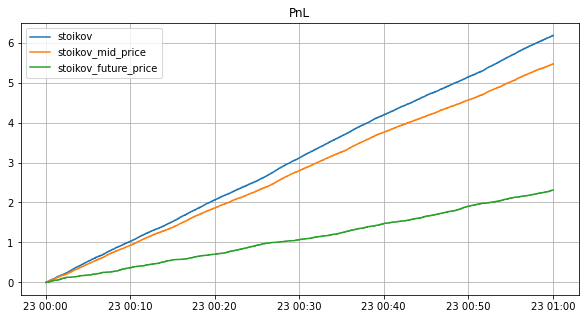

In [14]:
plt.figure(figsize=(10, 5))
plt.title("PnL")
for name, df in dfs.items():

    dt = pd.to_datetime(df.receive_ts)

    plt.step(dt, df.traded_volume, '-', label=name)
plt.legend()
plt.grid()
plt.show()

* However it makes much fewer trades than other strategies, and if we have good rebates, other strategies may make more sense

### Future price on all time horizon

In [18]:
T = pd.Timedelta(23, 'h').delta
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [19]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

#delay between orders
delay = pd.Timedelta(0.5, 's').delta

min_pos = 0.001

In [20]:
gamma = 1

In [21]:
T = pd.Timedelta(1, 's').delta

In [22]:
stoikov_future_price = FutureStrategy(delay=delay, min_pos=min_pos, time_memory=T, gamma=gamma, theta_policy='std', md = md)
res = stoikov_future_price.run(sim = Sim(md, latency, md_latency))
dfs = get_pnl(res['update'])

In [23]:
df = dfs

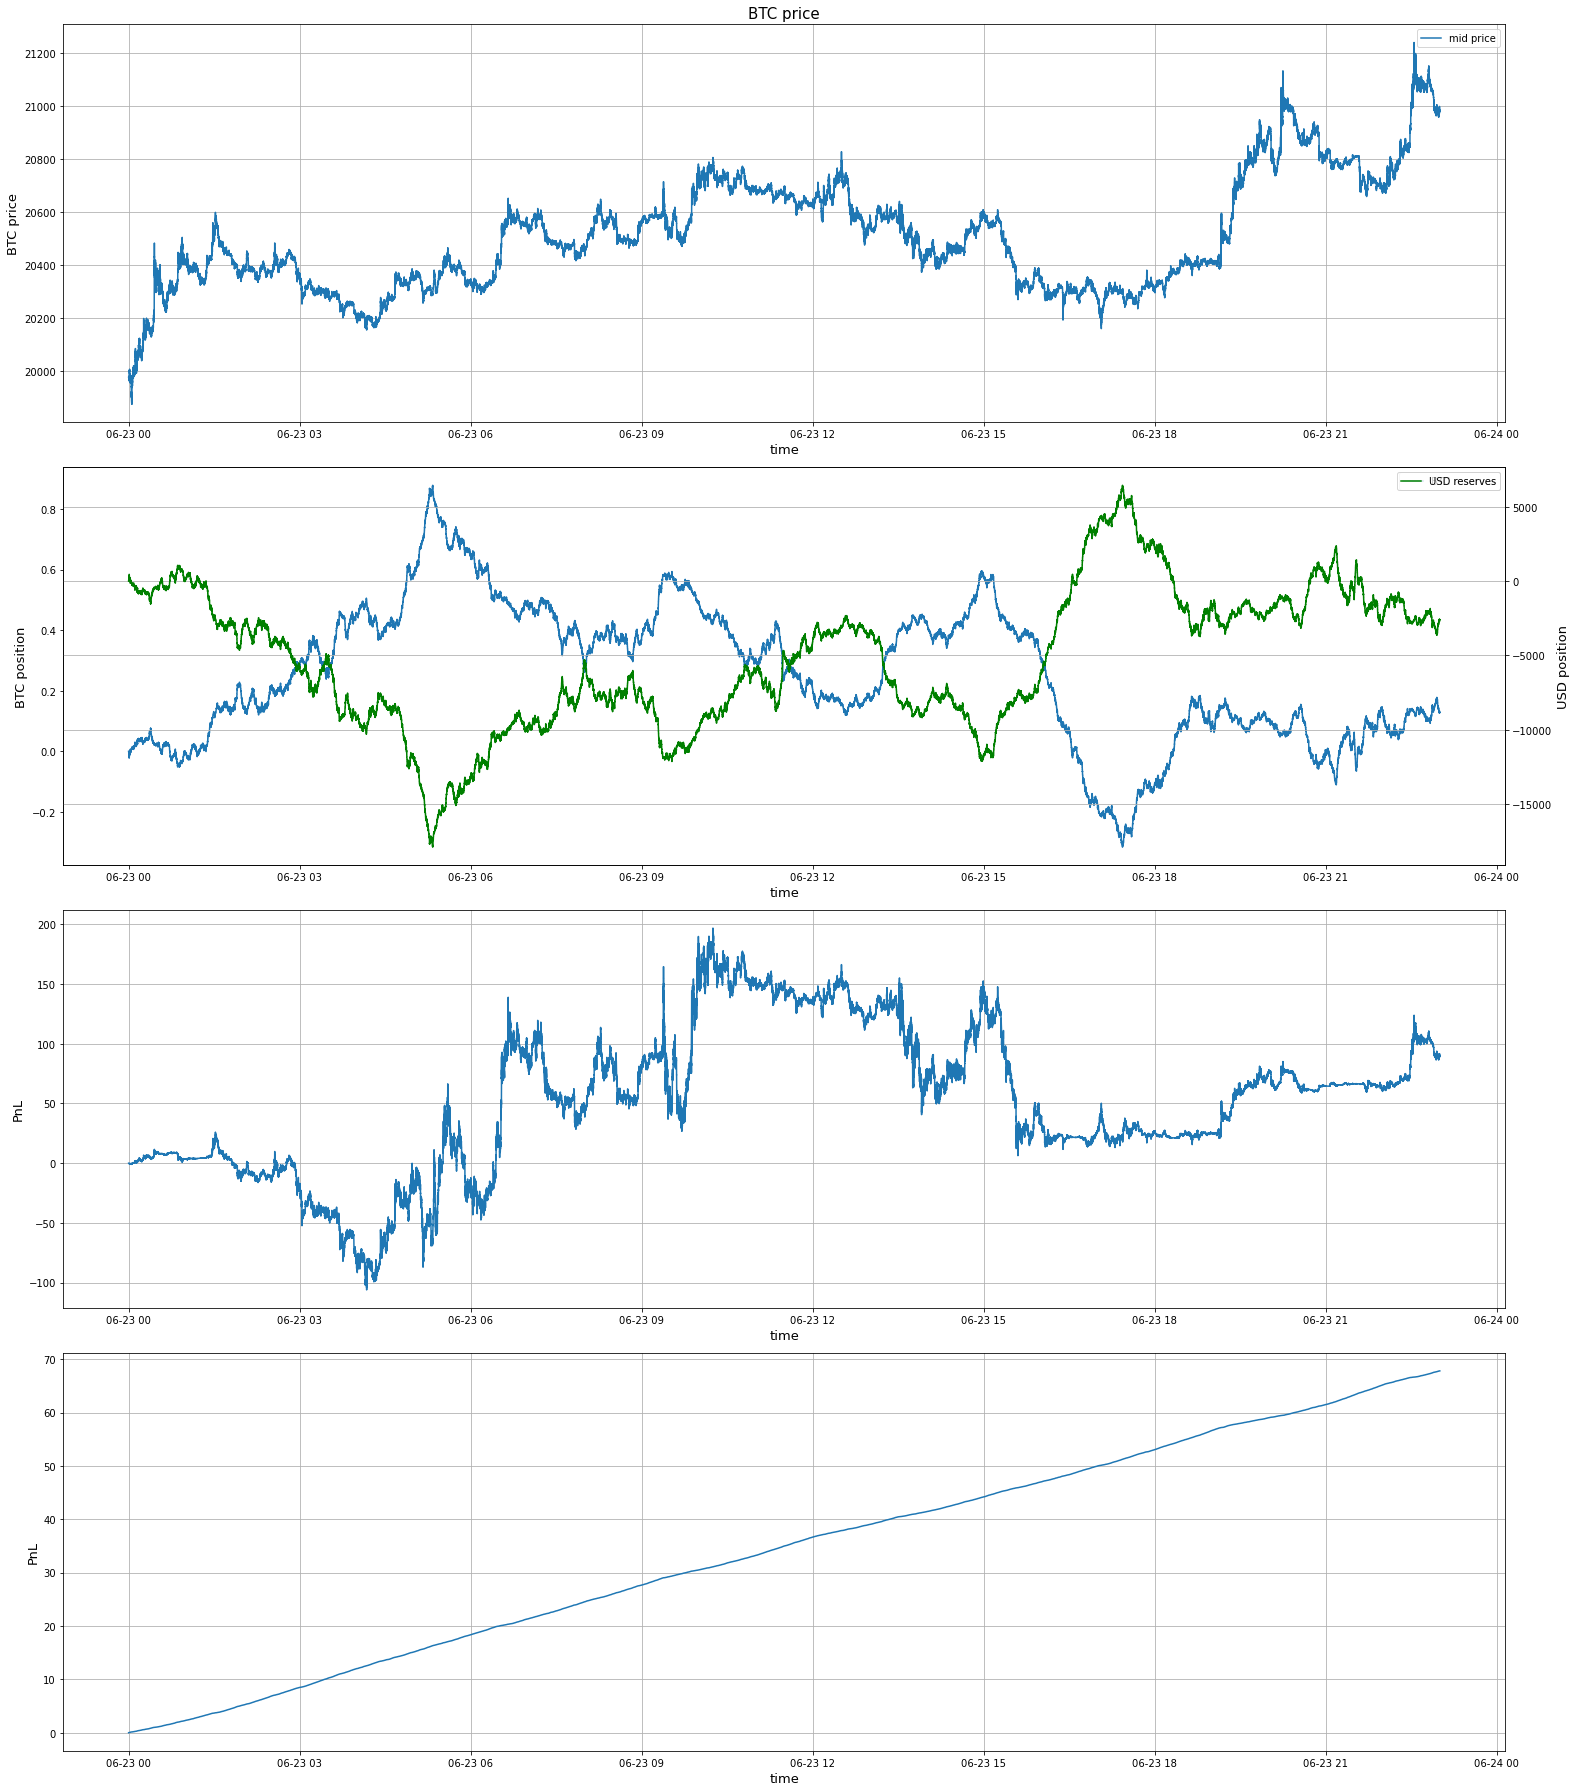

In [25]:
plt.figure(figsize=(22, 25))
dt = pd.to_datetime(df.receive_ts)

plt.subplot(4, 1, 1)
plt.plot(dt, df.mid_price, '-', label='mid price')
plt.xlabel("time", fontsize=13)
plt.ylabel("BTC price", fontsize=13)
plt.title("BTC price", fontsize=15)
plt.legend()
plt.grid()

ax1 = plt.subplot(4, 1, 2)
ax2 = ax1.twinx()
ax1.plot(dt, df.BTC, '-', label='BTC reserves')
ax2.plot(dt, df.USD, '-', color='g', label='USD reserves')
ax1.set_xlabel("time", fontsize=13)
ax1.set_ylabel("BTC position", fontsize=13)
ax2.set_ylabel("USD position", fontsize=13)
ax1.legend()
ax2.legend()
#plt.title("Inventory for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
#plt.title("PnL for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(dt, df.traded_volume, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
#plt.title("Cum Traded Volume for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
plt.grid()

plt.tight_layout()
plt.show()

### 3. Liquidation strategies